# 08/02 train-rmse:0.233459;	valid-rmse:0.242779
# 07/31 train-rmse:0.242975;	valid-rmse:0.249397

- **V** Number of characters in title
- **V** Number of characters in description
- **V** tfidf of description
- **V** tfidf of title
- Param_1,2,3 if has param?



- Number of words
- Number of numbers. i.e. 2010
- Average Word Length
- Number of stopwords
- Number of special characters

- if the description is empty (replace with 'NA' string is fine. and then create another boolean feature)
- try new features to see if the result improved
- search for keywords in description of title. i.e. "new" or "old"
- empty description will be 0 after tfidf?
- check the predicted value, see if they fall into [0,1]

In [16]:
import pandas as pd
pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np

In [17]:
# load dataset
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [ ]:
train["item_id"].is_unique

## Get relevant columns

In [3]:
def select_columns(data, *columns):
    return data.loc[:, columns]

#train=train[["item_id","title","description","deal_probability"]]
#test=test[["item_id","title","description"]]

## Checking missing values

In [61]:
s=train.isnull()
missing_counts_train = s[s == True].count()
s=test.isnull()
missing_counts_test = s[s == True].count()
missing_counts_train

item_id                      0
user_id                      0
region                       0
city                         0
parent_category_name         0
category_name                0
param_1                  61576
param_2                 654542
param_3                 862565
title                        0
description                  0
price                    85362
item_seq_number              0
activation_date              0
user_type                    0
image                   112588
image_top_1             112588
deal_probability             0
dtype: int64

In [ ]:
missing_counts_test

In the test dataset, there is not missing values in *description*. In other words, if *description* is empty or not might not be a good features?

In [20]:
def fix_missing_desc(data):
    data['description']=data['description'].fillna('NA')
    return data

def fix_missing_title(data):
    data['title']=data['title'].fillna('NA')
    return data

## Add features

In [5]:
def add_has_description(data):
    def check_na(s):
        if s=="NA":
            return 0
        else:
            return 1
        
    data['has_desc'] = data["description"].apply(check_na)
    return data

In [6]:
def add_char_len_title(data):
    data['char_len_title'] = data["title"].apply(lambda x: len(str(x)))
    return data

def add_char_len_desc(data):
    data['char_len_desc'] = data["description"].apply(lambda x: len(str(x)))
    return data

In [ ]:
train.head()

In [18]:
import nltk
from nltk.corpus import stopwords
stopWords = stopwords.words('russian')

In [ ]:
# need to change data type from object to unicode
train["description"].dtype

## Lowercase

In [21]:
def change_lowercase_title(data):
    data["title"] = data["title"].str.lower()
    return data

def change_lowercase_desc(data):
    data["description"] = data["description"].str.lower()
    return data

## Remove stopwords

In [ ]:
#def remove_stopwords_title(data, stopwords):
#    data["title"] = data["title"].str.lower()
#    return data

#def change_des_lowercase(data):
#    data["description"] = data["description"].str.lower()
#    return data

## Tokenized

## Morphological analyzer for Russian language (3hr)

In [9]:
def add_normalize_morph_title(data):
    import re
    import pymorphy2
    morph = pymorphy2.MorphAnalyzer()
    retoken = re.compile(r'[\'\w\-]+')
    
    def get_words(s):
        list_words = retoken.findall(s)
        return ' '.join([morph.parse(x)[0].normal_form for x in list_words])  
    
    data["title_norm"] = data["title"].apply(get_words)
    return data

def add_normalize_morph_desc(data):
    import re
    import pymorphy2
    morph = pymorphy2.MorphAnalyzer()
    retoken = re.compile(r'[\'\w\-]+')
    
    def get_words(s):
        list_words = retoken.findall(s)
        return ' '.join([morph.parse(x)[0].normal_form for x in list_words])  
    
    data["desc_norm"] = data["description"].apply(get_words)
    return data

#train['title'] = train['title'].astype(str)
#train['description'] = train['description'].astype(str)

#train['title'] = train['title'].apply(normalize)
#train['description'] = train['description'].apply(normalize)

In [ ]:
add_normalize_morph_desc(train[:5])

## TF-IDF

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# tfidf for title
def add_tfidf_title(data, num=100):
    tfidf = TfidfVectorizer(max_features=100, stop_words = stopWords)
    tfidf_title_train = np.array(tfidf.fit_transform(data['title'].values.astype('U')).todense(), dtype=np.float16)
    for i in range(num):
        data['tfidf_title_' + str(i)] = tfidf_title_train[:, i]
    return data

# tfidf for description
def add_tfidf_desc(data, num=100):
    tfidf = TfidfVectorizer(max_features=100, stop_words = stopWords)
    tfidf_des_train = np.array(tfidf.fit_transform(data['description'].values.astype('U')).todense(), dtype=np.float16)
    for i in range(num):
        data['tfidf_des_' + str(i)] = tfidf_des_train[:, i]
    return data

In [ ]:
train.head()

## Reusable Pipeline

In [23]:
def process_data(data):

    data = (
        data
        # Clean Data
        .pipe(fix_missing_title)
        .pipe(fix_missing_desc)
        .pipe(change_lowercase_title)
        .pipe(change_lowercase_desc)
        
        # Transform data
        .pipe(select_columns, 
              "item_id",
              "title",
              "description",
              "deal_probability"
             )
        .pipe(add_char_len_title)
        .pipe(add_char_len_desc)
        .pipe(add_tfidf_title)
        .pipe(add_tfidf_desc)
        #.pipe(add_keywords_desc)
        #.pipe(add_has_description)
    ) 
    
    # Return predictors and response variables separately
    X = data.drop(['deal_probability'], axis = 1)
    y = data['deal_probability'] # all nan if not exist 
    
    return X, y

In [24]:
X_train, y_train = process_data(train)

In [13]:
X_test, y_test = process_data(test)

/Users/winnielee/code/.virtualenvs/gdso/lib/python3.6/site-packages/pandas/core/indexing.py:870: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_lowerdim(tup)


## split train and validation dataset

In [14]:
X_train = X_train.drop(['item_id','title','description'],axis=1)
X_test = X_test.drop(['item_id','title','description'],axis=1)

In [15]:
# split train and test dataset
from sklearn.model_selection import train_test_split

# for training and validating model
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(1202739, 202) (300685, 202) (1202739,) (300685,)


In [ ]:
#X_train = X_train.drop(['has_desc'],axis=1)
#X_val = X_val.drop(['has_desc'],axis=1)

## Cross-validation for selecting model parameters

In [ ]:
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBRegressor(
        n_jobs = 1,
        objective = 'regression',
        eval_metric = 'rmse',
        silent=1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [16]:
import xgboost as xgb

# grid search result
params = {'eta': 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'reg:logistic', 
          'eval_metric': 'rmse', 
          'random_state': 99, 
          'silent': True}

tr_data = xgb.DMatrix(X_train, y_train)
va_data = xgb.DMatrix(X_val, y_val)
#del X_train
#del X_val
#del y_train
#del y_val
#import gc
#gc.collect()

watchlist = [(tr_data, 'train'), (va_data, 'valid')]

model = xgb.train(params, tr_data, 1000, watchlist, maximize=False, early_stopping_rounds = 25, verbose_eval=5)

[0]	train-rmse:0.35984	valid-rmse:0.360379
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 25 rounds.
[5]	train-rmse:0.248485	valid-rmse:0.251781
[10]	train-rmse:0.240376	valid-rmse:0.245139
[15]	train-rmse:0.238068	valid-rmse:0.244403
[20]	train-rmse:0.236455	valid-rmse:0.244349
[25]	train-rmse:0.235028	valid-rmse:0.244412
[30]	train-rmse:0.233723	valid-rmse:0.244545
[35]	train-rmse:0.232563	valid-rmse:0.244643
[40]	train-rmse:0.231457	valid-rmse:0.244781
Stopping. Best iteration:
[18]	train-rmse:0.237067	valid-rmse:0.244329



In [ ]:
X_test.head()

In [26]:
# generate result for test dataset
X_test_dmatrix = xgb.DMatrix(X_test)
y_pred = model.predict(X_test_dmatrix, ntree_limit=model.best_ntree_limit)
sub = pd.read_csv('data/sample_submission.csv')
sub['deal_probability'] = y_pred
sub['deal_probability'].clip(0.0, 1.0, inplace=True)
sub.to_csv('predictions/nlp.csv', index=False)
sub.head()

,item_id,deal_probability
0,6544e41a8817,0.05533
1,65b9484d670f,0.11374
2,8bab230b2ecd,0.17069
3,8e348601fefc,0.31488
4,8bd2fe400b89,0.22598


In [20]:
train = pd.read_csv('data/train.csv')

In [21]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.00000,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.00000,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.00000,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.00000,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.00000,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.00000,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.00000,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.00000,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.00000,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.00000,0.20797


In [22]:
train_template=train[["item_id", "deal_probability"]]

In [23]:
train_template.head()

,item_id,deal_probability
0,b912c3c6a6ad,0.12789
1,2dac0150717d,0.00000
2,ba83aefab5dc,0.43177
3,02996f1dd2ea,0.80323
4,7c90be56d2ab,0.20797


In [24]:
train_template.to_csv('data/nlp_train.csv', index=False)

In [25]:
X_train, y_train = process_data(train)
X_train = X_train.drop(['item_id','title','description'],axis=1)

X_train_dmatrix = xgb.DMatrix(X_train)
y_pred = model.predict(X_train_dmatrix, ntree_limit=model.best_ntree_limit)
sub = pd.read_csv('data/nlp_train.csv')
sub['deal_probability'] = y_pred
sub['deal_probability'].clip(0.0, 1.0, inplace=True)
sub.to_csv('data/nlp_train.csv', index=False)
sub.head()

,item_id,deal_probability
0,b912c3c6a6ad,0.10939
1,2dac0150717d,0.17396
2,ba83aefab5dc,0.25673
3,02996f1dd2ea,0.19680
4,7c90be56d2ab,0.34485


In [ ]:
# plotting 

#from xgboost import plot_importance
#import matplotlib.pyplot as plt
#plot_importance(model)
#plt.gcf().savefig('feature_importance_xgb.png')


## Translate top words
А а, Б б, В в, Г г, Д д, Е е, Ё ё, Ж ж, З з, И и, Й й, К к, Л л, М м, Н н, О о, П п, Р р, С с, Т т, У у, Ф ф, Х х, Ц ц, Ч ч, Ш ш, Щ щ, Ъ ъ, Ы ы, Ь ь, Э э, Ю ю, Я я

In [25]:
tfidfvec=TfidfVectorizer()
dtm_tfidf_train=tfidfvec.fit_transform(X_train["description"])
#dtm_tfidf_test = tfidfvec.transform(test["description"])
# get words
tfidfvec.get_feature_names()

['00',
 '000',
 '0000',
 '00000',
 '000000',
 '0000000',
 '000000000',
 '00000001',
 '0000000111',
 '00000016',
 '00000023',
 '00000024281',
 '0000003',
 '00000033512',
 '00000034404',
 '00000046088',
 '00000052332',
 '00000057463',
 '00000060',
 '00000078968',
 '00000078978',
 '00000087',
 '00000090',
 '00000091',
 '00000092',
 '000001',
 '0000010',
 '00000112',
 '00000114',
 '0000012',
 '00000157',
 '00000171',
 '00000180',
 '00000189',
 '00000190',
 '00000192',
 '00000202',
 '00000204',
 '00000205',
 '00000206',
 '00000305',
 '00000306',
 '0000033508',
 '00000343',
 '00000349',
 '00000482',
 '000005',
 '00000547',
 '00000549',
 '0000055',
 '00000596',
 '0000060',
 '00000614',
 '00000615',
 '00000619',
 '000007',
 '000008',
 '0000088',
 '00000912',
 '00000942',
 '0000099',
 '00001',
 '000010',
 '00001046',
 '00001213',
 '000014',
 '000016',
 '000018',
 '000019',
 '00001987',
 '00002',
 '00002003',
 '00002029',
 '000021',
 '00002179',
 '00002262',
 '00002291',
 '00002395',
 '00002570'

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(max_features=100, stop_words = stopWords, analyzer="word", token_pattern="[^0-9\s]{2,}")
tfidf = vec.fit_transform(X_train["description"])
potential_words=vec.get_feature_names()
len(potential_words)

100

In [31]:
list_words=vec.get_feature_names()

In [37]:
idf = vec.idf_
for i in range(100):
    print(list_words[i], translated_list_words[i], idf[i])
#print dict(zip(vec.get_feature_names(), idf))

-х -x 5.18218318107288
./ ./ 5.281702643218987
na on 3.5593280580548146
автомобиль car 5.643630923931981
б/у boo 4.94975821690168
большой big 5.159692896178807
вес the weight 5.323224808998833
внутри within 5.592102639530424
возможен available 5.035605454885287
возможна is possible 5.3336142508474955
возможность opportunity 5.656711191131276
вопросы issues 5.106110131922447
время time 5.151503954221222
высота height 5.192871910837091
г. in 5.196489827865271
гарантия guarantee 5.363772979523498
года of the year 5.318120203779918
две two 5.489134689659181
детский children's 5.502550506651854
длина length 4.897872799459532
дом house 4.722031848270156
дома at home 5.449763640641629
доме house 5.585950385031221
доставка delivery 4.853992888813176
есть/ there is/ 6.767087906983107
звоните call 5.116583132052178
идеальном ideal 4.834630327195437
имеется there is 5.329213302853442
квартира apartment 4.660385293618306
квартиру flat 5.016484128346254
количество quantity 5.687143685386472
комплек

In [ ]:
potential_words

In [33]:
# translate keywords
from googletrans import Translator
def translate_ru_to_en(potential_words):
    translator = Translator()
    result=[translator.translate(origin, src='ru', dest='en').text for origin in potential_words]
    return result
    
    

def translate_title_and_description(file_path, prefix, title_only, desc_only):
    
    if title_only == 'yes':
        translate(file_path, prefix, "title")
    elif desc_only == 'yes':
        translate(file_path, prefix, "description")
    else:
        translate(file_path, prefix, "title")
        translate(file_path, prefix, "description")

In [35]:
translated_list_words=translate_ru_to_en(list_words)

In [ ]:
potential_words_ru=translate_ru_to_en(potential_words)

In [ ]:
for i in range(100):
    print("{}, {}".format(potential_words_ru[i], potential_words[i]))
    
# car, автомобиль
# big, большой
# house, дом, доме
# apartment, квартира
# flat, квартиру

# ideal, идеальном
#the new, новая
#new, новые
#new, новый
#excellent, отличное
#excellent, отличном
#highly, очень
#good, хорошее
#good, хорошем

#for sale, продается
#selling, продам
#selling, продаю
#for sale, продаётся
#bargain, торг
#bargain., торг.

# available, возможен
# guarantee, гарантия

## Check if keywords exist

In [ ]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    import re
    def getIndicator(email):
        
        lst=np.zeros(len(words))
        
        for i, word in enumerate(words):
            
            tmp=[]
            if len(re.findall(word, email))>0:
                
                lst[i]=1
            else:
                
                lst[i]=0
        return lst
     
    indicator=texts.apply(getIndicator)
    indicator_array = np.array(indicator.tolist())
    # YOUR CODE HERE
    
    return indicator_array

In [ ]:
target_keyword=[# ideal, 
    "идеальном",
#the new, 
    "новая",
#new, 
    "новые",
#new, 
    "новый",
#excellent, 
    "отличное",
#excellent, 
    "отличном",
#highly, 
    "очень",
#good, 
    "хорошее",
#good, 
    "хорошем"]
potential_words_matrix=words_in_texts(target_keyword,train["description"])

In [ ]:
df_potential_words=pd.DataFrame(potential_words_matrix, columns=target_keyword)

In [ ]:
def add_keywords_desc(data):
    
    return data

In [ ]:
keywords_matrix.shape

In [ ]:
df_potential_words

In [ ]:
X_train=pd.concat([X_train, df_potential_words], axis=1)

In [ ]:
test_pd

In [ ]:
X_train.head()

In [38]:
english=["quantity", "house", "for sale", "phone", "children's", "guarantee", "bundle", "excellent", "delivery", "condition", "NA"]
weights=[5.687143685, 5.585950385, 5.523784015, 5.520967457, 5.502550507, 5.36377298, 5.157267415, 5.083669582, 4.853992889, 4.054061446, 3.559328058]


d = {'col1': english, 'col2': weights}
df = pd.DataFrame(data=d)

In [39]:
df

,col1,col2
0,quantity,5.68714
1,house,5.58595
2,for sale,5.52378
3,phone,5.52097
4,children's,5.50255
5,guarantee,5.36377
6,bundle,5.15727
7,excellent,5.08367
8,delivery,4.85399
9,condition,4.05406


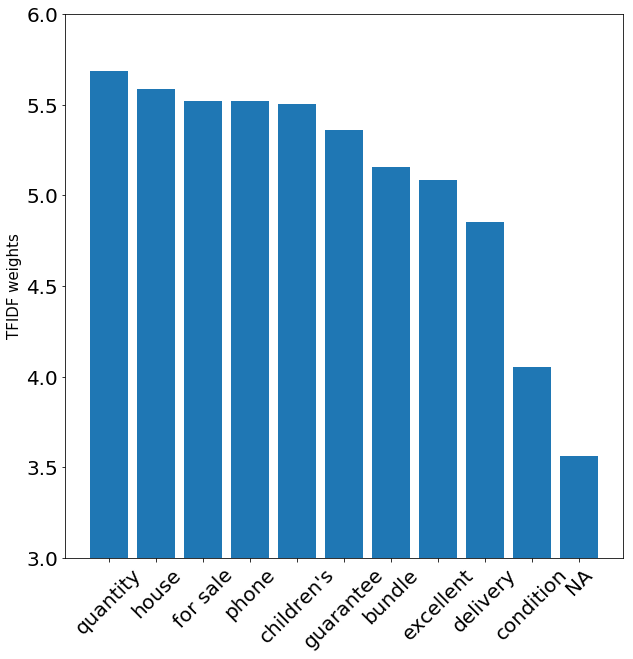

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
#plt.xlabel('keywords', size = 15)
plt.ylabel('TFIDF weights', size = 15)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.bar(df["col1"], df["col2"])
#ymin, ymax = ylim()  # return the current ylim
plt.ylim(3, 6)   # set the ylim to ymin, ymax
plt.xticks(rotation=45)
plt.show;